In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Input,Sequential,load_model,Model
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation,merge,Concatenate,AveragePooling2D,BatchNormalization,MaxPool2D ,GlobalAvgPool2D,Dropout,ReLU,AvgPool2D, Flatten, Dense, Lambda, add,concatenate,GlobalAveragePooling2D,PReLU,SpatialDropout2D,ConvLSTM2D
from keras.initializers import he_normal,glorot_normal,glorot_uniform
import tensorflow_addons as tfa
import keras.backend as K
import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from keras import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import os
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.metrics import plot_det_curve
from sklearn.metrics import DetCurveDisplay,det_curve
import sklearn

In [ ]:
num_classes = 2
sgd_initial_learning_rate=0.001
Adam_initial_learning_rate=0.00001
batch_size = 64
epochs = 100
lr=0.001
patience_iter = 1
patience=10
best_model_file = '/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/LightCnn_blackman_frames864_sgd_epochs_batch32.h5'


In [ ]:
#img_rows=256,FrameLen=256,FrameInc=64,NFFT=800,winfunc=np.blackman
def featProcess():
    trainData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/train/train.npy')
    trainLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/train_lable/train_lable.npy')
    
    devData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/dev/dev.npy')
    devLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spec_400_400_100_800/dev_lable/dev_lable.npy')

    #evalData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_256time_256frame_length_64step_800fft/eval/eval_1.npy')
    #evalLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_256time_256frame_length_64step_800fft/eval_lable/eval_1_label.npy')
    
    #trainData = np.concatenate((trainData,devData))
    #trainLabel = np.concatenate((trainLabel,devLabel)) 
    
    img_rows, img_cols =trainData[0].shape
    
    x_train = trainData.reshape(trainData.shape[0], img_rows, img_cols, 1)
    #y_train=trainLabel.astype(np.float64)
    y_train = keras.utils.np_utils.to_categorical(trainLabel,num_classes)
    #y_train = trainLabel
    
    x_dev = devData.reshape(devData.shape[0], img_rows, img_cols, 1)
    #y_dev=devLabel.astype(np.float64)
    y_dev = keras.utils.np_utils.to_categorical(devLabel,num_classes)
    #y_dev = devLabel
    
    #x_test = evalData.reshape(evalData.shape[0], img_rows, img_cols, 1)
    #y_test = keras.utils.np_utils.to_categorical(evalLabel,num_classes)
    #y_test = evalLabel
    
 
    return x_train,y_train,trainLabel,x_dev,y_dev,devLabel#,x_test,y_test,evalLabel

In [ ]:
x_train,y_train,trainLabel,x_dev,y_dev,devLabel= featProcess()

In [ ]:
type(y_train[1])

numpy.ndarray

In [ ]:
def EER_score(y,y_pred_prob,pos_label=1):
    fpr,tpr,thresholds = roc_curve(y,y_pred_prob)
    fnr = 1 - tpr
    EER_fpr = fpr[np.nanargmin(np.absolute((fnr-fpr)))]
    EER_fnr = fnr[np.nanargmin(np.absolute((fnr-fpr)))]
    EER = (EER_fpr+EER_fnr)/2
    return EER*100

In [ ]:
def auc(y_true,y_pred):
    
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0,1,1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0,1,1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)),pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s,axis=0)

In [ ]:
def binary_PFA(y_true,y_pred,threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold,'float32')
    N = K.sum(1-y_true)
    FP = K.sum(y_pred-y_pred*y_true)
    return FP/N

In [ ]:
def binary_PTA(y_true,y_pred,threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold,'float32')
    P = K.sum(1-y_true)
    TP = K.sum(y_pred-y_pred*y_true)
    return TP/P 

In [ ]:
def CalEER(y,y_pred_prob):
    fpr,tpr,thresholds = roc_curve(y,y_pred_prob)
    fnr = 1 - tpr
    eer_thresholds = thresholds[np.nanargmin(np.absolute((fnr-fpr)))]
    print ("eer_thresholds:",eer_thresholds)
    EER_fpr = fpr[np.nanargmin(np.absolute((fnr-fpr)))]
    EER_fnr = fnr[np.nanargmin(np.absolute((fnr-fpr)))]
    EER = (EER_fpr+EER_fnr)/2
    print ("EER_fpr:",EER_fpr*100)
    print ("EER_fnr:",EER_fnr*100)
    print ("EER:",EER*100)
    plt.plot(fpr,tpr,color="red")
    plt.plot(np.arange(0.0,1.0,0.01),1.0-np.arange(0.0,1.0,0.01),color="blue")
    plt.annotate(EER*100,xy=(EER,1-EER),xytext=(0.1+EER,1-EER),
                 arrowprops=dict(arrowstyle='->',connectionstyle='arc3'))
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.title("ROC curve for cnn_vit classifier")
    plt.xlabel("False Positive Rate (1-Specificity)")
    plt.ylabel("True positive Rate (Sensitivity)")
    plt.grid(True)
    plt.show()
    return eer_thresholds

In [ ]:
def analysisModel(y,y_pred):
    print(classification_report(y,y_pred))
    confusion = confusion_matrix(y,y_pred)
    TP = confusion[1,1]
    FP = confusion[0,1]
    TN = confusion[0,0]
    FN = confusion[1,0]
    print("TP:",TP,"FN:",FN)
    print("FP:",FP,"TN:",TN)
    print("Recall:",recall_score(y,y_pred)*100)#TPR,sensitivity
    print("Specificity:",TN / float(TN+FP)*100)#TNR
    print("1-Specificity",FP / float(TN+FP)*100)#FPR
    print("Precision:",precision_score(y,y_pred)*100)

In [ ]:
class EERMetricCallback(tf.keras.callbacks.Callback):
    def __init__(self,predict_batch_size=1024,validation_data=None,include_on_batch=False):
        super(EERMetricCallback,self).__init__()
        self.predict_batch_size=predict_batch_size
        self.include_on_batch=include_on_batch
        self.validation_data=validation_data
    def on_batch_begin(self,batch,logs={}):
        pass
    
    def on_batch_end(self,batch,logs={}):
        pass
        '''
        if (self.include_on_batch):
            logs['eer_val']=float('-inf')
            if (self.validation_data):
                logs['eer_val']=EER_score(self.validation_data[1],
                    self.model.predict(self.validation_data[0],batch_size=self.predict_batch_size))
        '''       
    def on_train_begin(self,logs={}):
        self.params['metrics']=[]
        if not ('eer_val' in self.params['metrics']):
            self.params['metrics'].append('eer_val')
            
            
    def on_train_end(self,logs={}):
        logs['eer_val']=float('-inf')
        if (self.validation_data):
            logs['eer_val']=EER_score(self.validation_data[1][:,1],
                self.model.predict(self.validation_data[0],batch_size=self.predict_batch_size)[:,1])
    
    def on_epoch_begin(self,epoch,logs={}):
        pass
    
    def on_epoch_end(self,epoch,logs={}):
        pass

In [ ]:
class PerformanceVisualizationCallback(keras.callbacks.Callback):
    def __init__(self, model, validation_data, image_dir,predict_batch_size=1024):
        super(PerformanceVisualizationCallback,self).__init__()
        self.model = model
        self.validation_data = validation_data
        self.predict_batch_size=predict_batch_size
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred =np.asarray(self.model.predict(self.validation_data[0],batch_size=self.predict_batch_size)[:,1])
        y_true = self.validation_data[1]            
        y_pred_class=np.where(y_pred > 0.5, 1,0)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        plot_roc(y_true, y_pred, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

In [ ]:
decay = Adam_initial_learning_rate / epochs
def lr_scheduler(epoch, lr):
    #learning_rate =lr * 1 / (1 + 25000*decay * epoch)
    #print('learning_rate is %f' % learning_rate)
    if epoch >= 0.3*epochs:
            learning_rate =lr #* 1 / (1 + 1000*decay * epoch)
    #elif epoch >= 0.7*epochs:
            #learning_rate =lr * 1 / (1 + 5000*decay * epoch)
    #elif epoch >= 0.5*epochs:
            #learning_rate =lr * 1 / (1 + 10000*decay * epoch)
    #elif epoch >= 0.3*epochs:
            #learning_rate =lr * 1 / (1 + 20000*decay * epoch)
    elif epoch >= 0.2*epochs:
            learning_rate =lr * 1 / (1 + 50000*decay * epoch)
    elif epoch >= 0.1*epochs:
            learning_rate =lr * 1 / (1 + 100000*decay * epoch)
    else:
            learning_rate = Adam_initial_learning_rate
    print('learning_rate is %3f' % learning_rate)
    return learning_rate

In [ ]:
class patchEmbeding2(tf.keras.layers.Layer):
    def __init__(self , num_of_patches, projection_dim):

      super(patchEmbeding2, self).__init__()
      self.num_of_patches=num_of_patches + 1
      self.projection_dim=projection_dim
      
      self.projection=tf.keras.layers.Dense(projection_dim)
      self.clstoken=tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 ,projection_dim)),trainable=True)

      self.positionalEmbedding=tf.keras.layers.Embedding(self.num_of_patches , projection_dim) #give a vector for each pateches
    def get_config(self):
        cfg = super().get_config()
        return cfg 
      
    def call(self, inputs):
      patches = tf.reshape(inputs ,(tf.shape(inputs)[0] , -1 , tf.shape(inputs)[3]))
      patches=self.projection(patches)
      clstoken=tf.repeat(self.clstoken, tf.shape(inputs)[0],0) #repeat it with size of our batch_size
      #print('patches',patches.shape)
      #print('clstoken',clstoken.shape)

      patches=tf.concat((clstoken , patches), axis=1)
      #print('patches',patches.shape)

      positions=tf.range(0,self.num_of_patches,1)[tf.newaxis, ...]
      positionalEmbedding=self.positionalEmbedding(positions)
      #print('positionalEmbedding',positionalEmbedding.shape)
      patches = patches + positionalEmbedding


      return patches

In [ ]:
embed=patchEmbeding2(144,128)

In [ ]:
resualt=embed(tf.random.normal(shape=(32,12,12,128)))

patches (32, 144, 128)


In [ ]:
class patchEmbeding(tf.keras.layers.Layer):
    def __init__(self,size , num_of_patches, projection_dim):

      super(patchEmbeding, self).__init__()
      self.size=size
      self.num_of_patches=num_of_patches + 1
      self.projection_dim=projection_dim
      
      self.projection=tf.keras.layers.Dense(projection_dim)

      self.clstoken=tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 ,projection_dim)),trainable=True)

      self.positionalEmbedding=tf.keras.layers.Embedding(self.num_of_patches , projection_dim) #give a vector for each pateches
      
    def get_config(self):
        cfg = super().get_config()
        return cfg
    def call(self, inputs):
      patches=tf.image.extract_patches(inputs, sizes=[1, self.size , self.size ,1],
                                     strides=[1, self.size ,self.size ,1],
                                     rates=[1 ,1 ,1 ,1 ],
                                     padding="VALID")
      patches = tf.reshape(patches ,(tf.shape(inputs)[0] , -1 , self.size * self.size*128))
      patches=self.projection(patches)
      clstoken=tf.repeat(self.clstoken, tf.shape(inputs)[0],0) #repeat it with size of our batch_size
      #print('patches',patches.shape)
      #print('clstoken',clstoken.shape)

      patches=tf.concat((clstoken , patches), axis=1)
      #print('patches',patches.shape)

      positions=tf.range(0,self.num_of_patches,1)[tf.newaxis, ...]
      positionalEmbedding=self.positionalEmbedding(positions)
      #print('positionalEmbedding',positionalEmbedding.shape)
      patches = patches + positionalEmbedding


      return patches

In [ ]:
embed=patchEmbeding(2,36,256)

In [ ]:
patches=tf.image.extract_patches( tf.random.normal(shape=(1,12,12,128)), sizes=[1,2,2,1] , strides=[1,2,2,1] ,
                                 rates=[1,1,1,1],
                                 padding='VALID')
patches.shape

TensorShape([1, 6, 6, 512])

In [ ]:
tf.reshape(patches , shape=(tf.shape(patches)[0], -1 ,2*2*128 ))

<tf.Tensor: shape=(1, 36, 512), dtype=float32, numpy=
array([[[-0.3983133 , -0.48323166,  0.08266178, ..., -0.04102889,
          0.22930819, -0.7151884 ],
        [-0.0979531 , -0.26912013, -0.9999731 , ...,  0.52167356,
          1.4202849 , -1.7242944 ],
        [-0.5770695 ,  0.3112506 ,  1.6219804 , ..., -0.83910805,
          0.45026758, -0.17033817],
        ...,
        [-0.35381168,  0.7342255 ,  0.76474   , ...,  0.9180015 ,
         -1.0126871 , -0.66319627],
        [ 1.6402308 , -0.5822414 ,  1.1530813 , ...,  0.7195015 ,
         -0.31061307, -0.8337957 ],
        [-0.48802185,  0.7612229 ,  2.529092  , ..., -0.2833187 ,
          0.13183562, -1.5624676 ]]], dtype=float32)>

In [ ]:
resualt=embed(tf.random.normal(shape=(32,12,12,128)))

patches (32, 36, 256)
clstoken (32, 1, 256)
patches (32, 37, 256)
positionalEmbedding (1, 37, 256)


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model = 512, num_heads = 8, causal=False, dropout=0.0):
    super(MultiHeadAttention, self).__init__()

    assert d_model % num_heads == 0
    depth = d_model // num_heads

    self.w_query = tf.keras.layers.Dense(d_model)
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth))  
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))      

    self.w_value = tf.keras.layers.Dense(d_model)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))

    self.w_key = tf.keras.layers.Dense(d_model)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout)
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))

    self.dense = tf.keras.layers.Dense(d_model)

  def get_config(self):
        cfg = super().get_config()
        return cfg

  def call(self, inputs, mask=None, training=None):
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v

    query = self.w_query(q)
    #print('query',query.shape)
    query = self.split_reshape_query(query)
    #print('query',query.shape)    
    query = self.split_permute_query(query)  
    #print('query',query.shape)               

    value = self.w_value(v)
    value = self.split_reshape_value(value)
    value = self.split_permute_value(value)
    #print('value',value.shape)

    key = self.w_key(k)
    key = self.split_reshape_key(key)
    key = self.split_permute_key(key)
    #print('key',key.shape)

    if mask is not None:
      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])

    attention = self.attention([query, value, key], mask=mask)
    attention = self.join_permute_attention(attention)
    attention = self.join_reshape_attention(attention)

    x = self.dense(attention)

    return x

In [ ]:
class transformerLayer1(tf.keras.layers.Layer):
  def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
    super(transformerLayer1, self).__init__()

    self.multi_head_attention =  MultiHeadAttention(d_model, num_heads)
    #self.mha=tf.keras.layers.MultiHeadAttention(num_heads , d_model//num_heads , dropout=dropout)
    self.dropout_attention = tf.keras.layers.Dropout(dropout)
    self.add_attention = tf.keras.layers.Add()
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dense2 = tf.keras.layers.Dense(d_model)
    self.dropout_dense = tf.keras.layers.Dropout(dropout)
    self.add_dense = tf.keras.layers.Add()
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)
  def get_config(self):
        cfg = super().get_config()
        return cfg

  def call(self, inputs, mask=None, training=None):
    # print(mask)
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask])
    #attention=self.mha(inputs , inputs , training=training)
    attention = self.dropout_attention(attention, training = training)
    x = self.add_attention([inputs , attention])
    x = self.layer_norm_attention(x)
    # x = inputs

    ## Feed Forward
    dense = self.dense1(x)
    dense = self.dense2(dense)
    dense = self.dropout_dense(dense, training = training)
    x = self.add_dense([x , dense])
    x = self.layer_norm_dense(x)

    return x

In [ ]:
trans=transformerLayer1(128,8,2048)

In [ ]:
trans(resualt)

<tf.Tensor: shape=(32, 145, 128), dtype=float32, numpy=
array([[[ 0.959501  ,  1.089794  , -0.41329738, ...,  0.26219815,
         -1.2889644 , -0.483917  ],
        [ 0.29328763, -0.75777644,  0.69454855, ...,  0.11654991,
          1.0160824 ,  0.95359325],
        [-1.0553534 ,  1.3015571 , -0.45465016, ...,  0.26432958,
         -0.6013083 ,  0.59645873],
        ...,
        [-0.20520483,  1.2858177 ,  1.3764408 , ...,  0.97675097,
         -1.5521413 , -0.9549011 ],
        [ 0.75707453, -0.24575618, -0.17124456, ..., -0.40727952,
          0.87844276,  1.2370319 ],
        [ 0.82464814, -0.6458366 , -0.3978269 , ...,  0.126959  ,
         -1.9098881 , -0.18396264]],

       [[ 1.2308321 , -0.11181029,  0.11463434, ..., -0.4021011 ,
         -0.6333492 , -1.2727433 ],
        [ 0.5247628 , -0.19136962,  0.11778574, ..., -1.0464709 ,
         -0.42525622,  1.1833227 ],
        [ 0.79709   ,  0.59102046,  1.0580161 , ...,  0.39414862,
          0.41547272,  1.189086  ],
        ...

In [ ]:
class TransformerEncoder1(tf.keras.layers.Layer):
    def __init__(self,d_model , heads, dff ,num_layers=1 ,dropout_rate=0.1):
      super().__init__()

      self.encoders=[transformerLayer1(d_model , heads , dff , dropout_rate) for _ in range(num_layers)] #stacking transformer layers in range of layers we define

    def get_config(self):
        cfg = super().get_config()
        return cfg 
    def call(self , inputs , training=True):
      x=inputs

      for layer in self.encoders:
        x=layer(x, training=training)

      return x

In [ ]:
class transformerLayer(tf.keras.layers.Layer):
    def __init__(self,d_model , heads, mlp_rate , dropout_rate=0.1):
      super().__init__()

      self.layernorm_1= tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.mha=tf.keras.layers.MultiHeadAttention(heads , d_model//heads , dropout=dropout_rate) #d_model is proj_dim

      self.layernorm_2= tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.mlp = tf.keras.Sequential([tf.keras.layers.Dense(d_model*mlp_rate , activation="gelu"),
                                      tf.keras.layers.Dropout(dropout_rate),
                                      tf.keras.layers.Dense(d_model , activation="gelu"),
                                      tf.keras.layers.Dropout(dropout_rate)])
    def get_config(self):
        cfg = super().get_config()
        return cfg 
      # we use training=True beacuse dropout shoudn't work in evaluation
    def call(self ,inputs , training=True):
      out_1 =self.layernorm_1(inputs)
      out_1=self.mha(out_1 , out_1 , training=training)
      out_1=inputs+out_1

      out_2=self.layernorm_2(out_1)
      out_2=self.mlp(out_2, training=training)
      out_2=out_1+ out_2

      return out_2

In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self,d_model , heads, mlp_rate ,num_layers=1 ,dropout_rate=0.1):
      super().__init__()

      self.encoders=[transformerLayer(d_model , heads , mlp_rate , dropout_rate) for _ in range(num_layers)] #stacking transformer layers in range of layers we define

    def get_config(self):
        cfg = super().get_config()
        return cfg 
    def call(self , inputs , training=True):
      x=inputs

      for layer in self.encoders:
        x=layer(x, training=training)

      return x

In [ ]:
def MFM(x):
    channels = x.shape[-1]
    mfm_out = tfa.layers.Maxout(int(channels / 2))(x)
    return mfm_out

def MFM_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4
    shape[-1] = shape[-1]/2
    return tuple(shape)

def buildLcnn_T():
	input_tensor = Input(shape=x_dev.shape[1:],name='input')
	x = Conv2D(32, (5,5), strides=(1,1), kernel_initializer=glorot_normal(),padding='same')(input_tensor)
	x = Lambda(MFM)(x)
	x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

	x = Conv2D(32, (1,1),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	x = Lambda(MFM)(x)
	x = Conv2D(64,(3,3),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	x = Lambda(MFM)(x)
	x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

	x = Conv2D(64, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	x = Lambda(MFM)(x)
	x = Conv2D(96, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	x = Lambda(MFM)(x) 
	x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	
	
	x = Conv2D(96, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	x = Lambda(MFM)(x)
	x = Conv2D(128, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	x = Lambda(MFM)(x)
	x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	

	x = Conv2D(256, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	x = Lambda(MFM)(x)
	x = Conv2D(256, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x) 
	x = Lambda(MFM)(x)
	x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
 

	embedding=patchEmbeding2(144,128) #num_of_patches, projection_dim
	x=embedding(x)
	enc=TransformerEncoder1(128,8,1024) #d_model , heads, dff ,num_layers=1 ,dropout_rate=0.1
	encoderResualt=enc(x)
	clsResult=encoderResualt[:,0,:]
	drop_1=Dropout(0.2)(clsResult)
	dense_1=Dense(2*32 , activation="gelu")(drop_1)
	drop_2=Dropout(0.2)(dense_1)
	output=Dense((2), activation = "softmax")(drop_2)
	model = Model(input_tensor,output)
	return model

In [ ]:
def MFM(x):
    channels = x.shape[-1]
    mfm_out = tfa.layers.Maxout(int(channels / 2))(x)
    return mfm_out

def MFM_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4
    shape[-1] = shape[-1]/2
    return tuple(shape)

def buildcnn_T_relu():
	input_tensor = Input(shape=x_dev.shape[1:],name='input')
	x = Conv2D(16, (5,5), strides=(1,1), kernel_initializer=glorot_normal(),padding='same')(input_tensor)
	#x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)


	x = Conv2D(32,(3,3),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	#x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

	x = Conv2D(64, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	#x = BatchNormalization()(x)
	x = Activation('relu')(x) 
	x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	
	
	x = Conv2D(96, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	#x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	

	x = Conv2D(128, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
	#x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
 

	embedding=patchEmbeding(1,144,128) #num_of_patches, projection_dim
	x=embedding(x)
	enc=TransformerEncoder1(128,8,1024,1,0.3) #d_model , heads, dff ,num_layers=1 ,dropout_rate=0.1
	encoderResualt=enc(x)
	clsResult=encoderResualt[:,0,:]
	drop_1=Dropout(0.2)(clsResult)
	dense_1=Dense(2*32 , activation="gelu")(drop_1)
	drop_2=Dropout(0.2)(dense_1)
	output=Dense((2), activation = "softmax")(drop_2)
	model = Model(input_tensor,output)
	return model

In [ ]:
def cnn_T_with_relu():
    input_tensor = Input(shape=x_train.shape[1:],name='input')
    x = Conv2D(16, (5,5), strides=(1,1), kernel_initializer=glorot_normal(),padding='same')(input_tensor)
    x = Activation("relu")(x)
    #x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)


    x = Conv2D(32,(3,3),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation("relu")(x)
    #x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)


    x = Conv2D(48, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation("relu")(x)
    #x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	
    

    x = Conv2D(64, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation("relu")(x)
    #x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	


    x = Conv2D(128, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x) 
    x = Activation("relu")(x)
    #x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

    x = Conv2D(256, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x) 
    x = Activation("relu")(x)
    #x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

    x = Conv2D(128, 16, strides=(16,16),kernel_initializer=glorot_normal(),padding='same')(x) 
    x = Activation("relu")(x)
    #x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    x = Flatten()(x)
    x = Dropout(0.9)(x)
    x = Dense(32,activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(num_classes,activation='softmax',name='output')(x)
    
    model = Model(input_tensor,x)

    return model

In [ ]:
def buildcnn_T_with_relu():
    input_tensor = Input(shape=x_train.shape[1:],name='input')
    x = Conv2D(16, (5,5), strides=(1,1), kernel_initializer=glorot_normal(),padding='same')(input_tensor)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)


    x = Conv2D(32,(3,3),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)


    x = Conv2D(48, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	
    
 
    x = Conv2D(64, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	


    x = Conv2D(128, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x) 
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
  

    embedding=patchEmbeding2(144,128) #num_of_patches, projection_dim
    x=embedding(x)
    enc=TransformerEncoder1(128,10,1024) #d_model , heads, dff ,num_layers=1 ,dropout_rate=0.1
    encoderResualt=enc(x)
    clsResult=encoderResualt[:,0,:]
    drop_1=Dropout(0.2)(clsResult)
    dense_1=Dense(2*32 , activation="gelu")(drop_1)
    drop_2=Dropout(0.2)(dense_1)
    output=Dense((2), activation = "softmax")(drop_2)
    model = Model(input_tensor,output)
    return model

#Densenet

In [ ]:
def Densenet(n_classes=2, f=12):
    def bn_rl_conv(x, f, k=1, s=1, p='same'):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x= Conv2D(f, (k,k), strides=(s,s),kernel_initializer=glorot_normal(),padding='same')(x) 
        #x = Conv2D(f, k, strides=s, padding=p)(x)
        return x
  
  
    def dense_block(tensor, r,dropout_rate):
        for _ in range(r):
          x = bn_rl_conv(tensor, 4*f)
          x = bn_rl_conv(x, f, 3)
          if dropout_rate>0:
            x = SpatialDropout2D(dropout_rate)(x)
          tensor = Concatenate()([tensor, x])
        return tensor
  
  
    def transition_block(x,dropout_rate):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        if dropout_rate>0:
          x = SpatialDropout2D(dropout_rate)(x)
        x = AvgPool2D(2, strides=2)(x)
        return x
    input = Input(shape=x_train.shape[1:],name='input')
    First_Conv2D = Conv2D(12, (7,7), padding='same',strides=(1,1),use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001),kernel_initializer=(keras.initializers.random_normal(stddev=np.sqrt(2.0/(9*16)))))(input)
    x = MaxPool2D(3, strides=2)(First_Conv2D)

    First_Block = dense_block(x, 6,0)
    First_Transition = transition_block(First_Block, 0)

    Second_Block = dense_block(First_Transition, 6, 0)
    Second_Transition = transition_block(Second_Block, 0)


    Third_Block = dense_block(Second_Transition, 6, 0)
    Third_Transition = transition_block(Third_Block, 0)

    forth_Block = dense_block(Third_Transition, 6, 0)
    forth_Transition = transition_block(forth_Block, 0)
    x = GlobalAvgPool2D()(forth_Transition)
  
    output = Dense(n_classes, activation='softmax')(x)
  
    model = Model(input, output)
    return model

In [ ]:
def Densenet_transformer(n_classes=2, f=12):
    def bn_rl_conv(x, f, k=1, s=1, p='same'):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x= Conv2D(f, (k,k), strides=(s,s),kernel_initializer=glorot_normal(),padding='same')(x) 
        #x = Conv2D(f, k, strides=s, padding=p)(x)
        return x
  
  
    def dense_block(tensor, r,dropout_rate):
        for _ in range(r):
          x = bn_rl_conv(tensor, 4*f)
          x = bn_rl_conv(x, f, 3)
          if dropout_rate>0:
            x = SpatialDropout2D(dropout_rate)(x)
          tensor = Concatenate()([tensor, x])
        return tensor
  
  
    def transition_block(x,dropout_rate):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        if dropout_rate>0:
          x = SpatialDropout2D(dropout_rate)(x)
        x = AvgPool2D(2, strides=2)(x)
        return x
    input = Input(shape=x_train.shape[1:],name='input')
    First_Conv2D = Conv2D(12, (7,7), padding='same',strides=(1,1),use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001),kernel_initializer=(keras.initializers.random_normal(stddev=np.sqrt(2.0/(9*16)))))(input)
    x = MaxPool2D(3, strides=2)(First_Conv2D)

    First_Block = dense_block(x, 6,0)
    First_Transition = transition_block(First_Block, 0)

    Second_Block = dense_block(First_Transition, 6, 0)
    Second_Transition = transition_block(Second_Block, 0)


    Third_Block = dense_block(Second_Transition, 6, 0)
    Third_Transition = transition_block(Third_Block, 0)

    forth_Block = dense_block(Third_Transition, 6, 0)
    forth_Transition = transition_block(forth_Block, 0)
    embedding=patchEmbeding2(144,68) #num_of_patches, projection_dim
    x=embedding(forth_Transition)
    enc=TransformerEncoder1(68,2,1024) #d_model , heads, dff ,num_layers=1 ,dropout_rate=0.1
    encoderResualt=enc(x)
    clsResult=encoderResualt[:,0,:]
    drop_1=Dropout(0.2)(clsResult)
    dense_1=Dense(2*32 , activation="gelu")(drop_1)
    drop_2=Dropout(0.2)(dense_1)
    output=Dense((2), activation = "softmax")(drop_2)
    model = Model(input,output)
    return model

In [ ]:
def block_unit( ):
    input_tensor = Input(shape=x_train.shape[1:],name='input')
    x = Conv2D(16, (5,5), strides=(1,1), kernel_initializer=glorot_normal(),padding='same')(input_tensor)
    x = Lambda(MFM)(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    
    y = Conv2D(16, (1,1),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    y = Lambda(MFM)(y)
    y = Conv2D(24,(3,3),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(y)
    y = Lambda(MFM)(y)
    x = concatenate([x,y])
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    
    y = Conv2D(24, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    y = Lambda(MFM)(x)
    x = Conv2D(32, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Lambda(MFM)(x)
    x = concatenate([x,y])
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	
    
    y = Conv2D(32, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    y = Lambda(MFM)(y)
    y = Conv2D(16, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(y)
    y = Lambda(MFM)(y)
    x = concatenate([x,y])
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)	
    
    y = Conv2D(16, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    y = Lambda(MFM)(y)
    y = Conv2D(16, (3,3), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(y) 
    y = Lambda(MFM)(y)
    x = concatenate([x,y])
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
	
    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(64,activation='relu')(x)
    x = Dense(num_classes,activation='softmax',name='output')(x)
    
    model = Model(input_tensor,x)    
    return model

In [ ]:
def buildNIN():
    input_tensor = Input(shape=x_train.shape[1:],name='input')
    x = Conv2D(64, (3,3), strides=(1,1), kernel_initializer=glorot_normal(),padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(64, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    
    x = Conv2D(64,(3,3),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(16, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
    
    x = Conv2D(8,(3,3),strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(4, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation('relu')(x)    
    x = Conv2D(2, (1,1), strides=(1,1),kernel_initializer=glorot_normal(),padding='same')(x)
    x = Activation('relu')(x)   
    
    x = GlobalAveragePooling2D(name='GAP')(x)
    x = Activation('softmax')(x)
    
    model = Model(input_tensor,x)
    return model

In [ ]:
import gc
gc.collect()

5814

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 400, 400, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 16)      416       
                                                                 
 activation (Activation)     (None, 400, 400, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 activation_1 (Activation)   (None, 200, 200, 32)      0         
                                                             

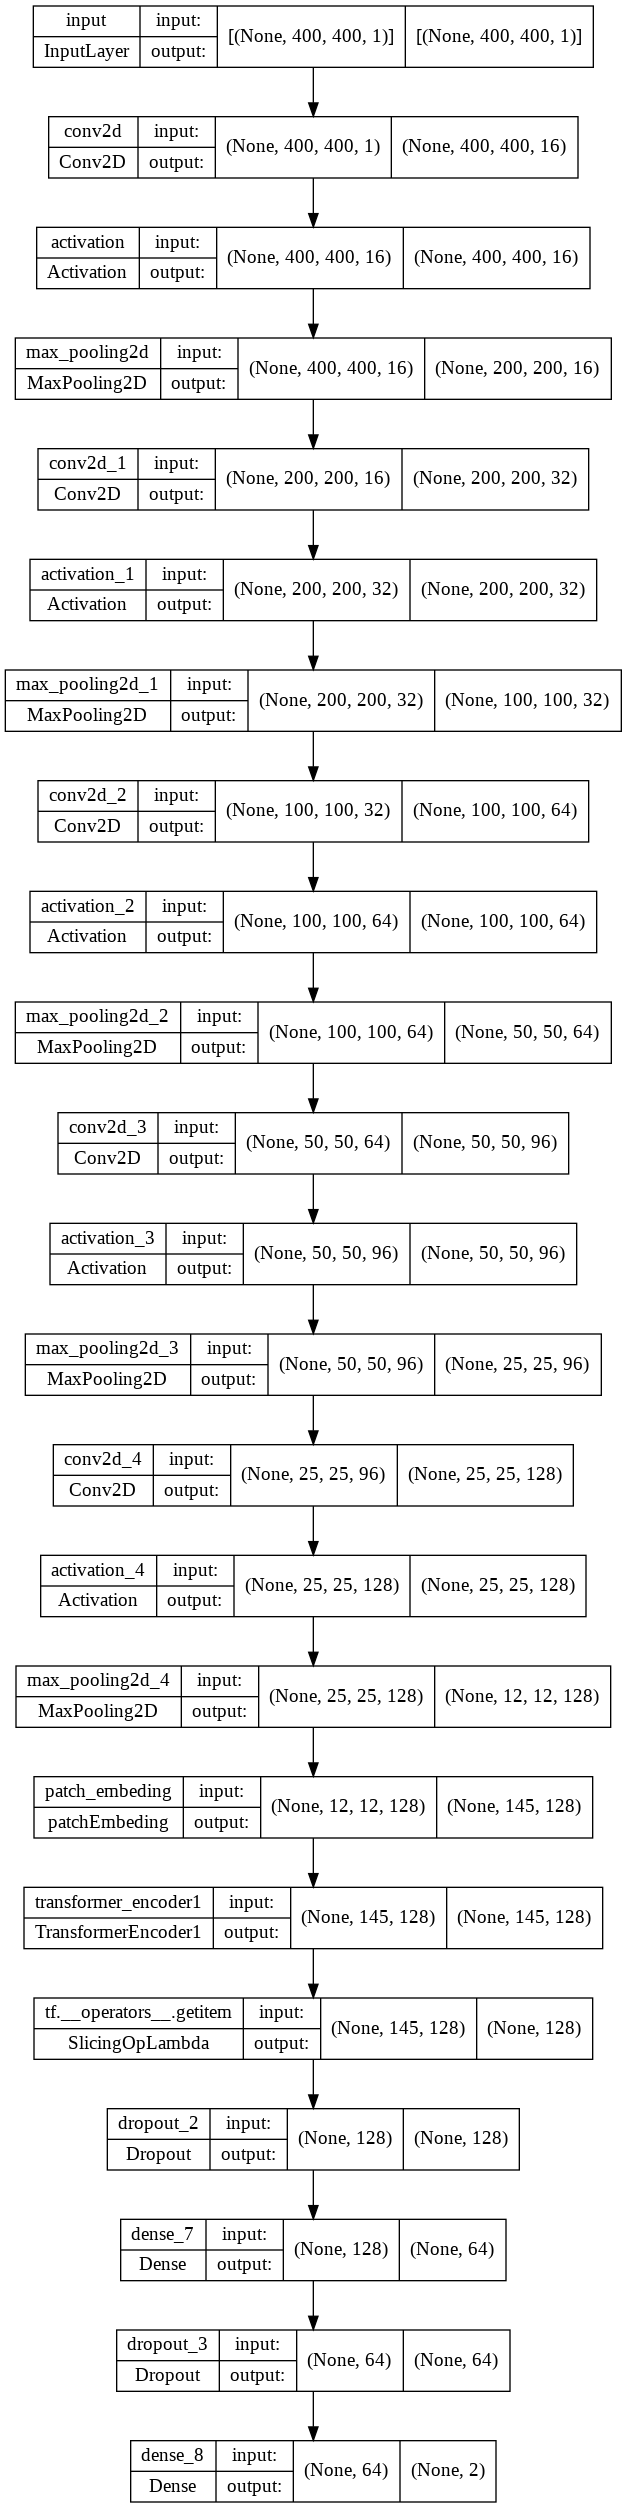

In [ ]:
model = buildcnn_T_relu()

print(model.summary())
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model.png', show_shapes=True)

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9,nesterov=True)
adadelta = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.9, epsilon=1e-6)
adam =tf.keras.optimizers.Adam(learning_rate=1e-5,beta_1=0.9,beta_2=0.999,epsilon=1e-8) 
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
#model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),optimizer=sgd,metrics=['accuracy'])
#model.compile(optimizer=adam,loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
nb_train_samples = x_train.shape[0]
    
train_datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images
    	# Compute quantities required for feature-wise normalization
    	# (std, mean, and principal components if ZCA whitening is applied).
    
train_datagen.fit(x_train)
train_generator = train_datagen.flow(x_train, y_train,batch_size=batch_size)
validation_data=(x_dev,y_dev)

In [ ]:
#history1 = LossHistory()
#eer_metric = EERMetricCallback(predict_batch_size=batch_size,validation_data=validation_data)
#performance_cbk = PerformanceVisualizationCallback(
#                      model=model,
#                      validation_data=validation_data,
#                      image_dir='/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/confusion_matrix',predict_batch_size=batch_size)

In [ ]:
cb=[#history1,
    #eer_metric,
    #performance_cbk,
    #wechat_utils.sendmessage(savelog=True,fexten='TEST'),
    ModelCheckpoint(best_model_file,monitor='val_loss',verbose=1,save_best_only=True,mode='min'),
    #LearningRateScheduler(lr_scheduler),
    EarlyStopping(monitor='val_loss',patience=patience,verbose=1,mode='min', restore_best_weights=True)
    ]

In [ ]:
# Fit the model on the batches generated by datagen.flow().
results =model.fit(train_generator,
                            steps_per_epoch=int(np.ceil(nb_train_samples / float(batch_size))),
                            epochs=epochs,
                            validation_data=validation_data,
                            verbose=1,
                            shuffle=True,
                            callbacks=cb,
                            workers=4)
    
model.save('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/2_6/cnn_viT_8head_dropout0.3_relu1_144patches_128filter_blackman_frames400_sgd_epochs100_lr0.0001.h5', model)

Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 0.8508 - accuracy: 0.5086
Epoch 1: val_loss improved from inf to 0.68444, saving model to /content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/LightCnn_blackman_frames864_sgd_epochs_batch32.h5
48/48 [==============================] - 17s 320ms/step - loss: 0.8508 - accuracy: 0.5086 - val_loss: 0.6844 - val_accuracy: 0.4784
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 0.7710 - accuracy: 0.5338
Epoch 2: val_loss improved from 0.68444 to 0.66490, saving model to /content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/LightCnn_blackman_frames864_sgd_epochs_batch32.h5
48/48 [==============================] - 14s 281ms/step - loss: 0.7710 - accuracy: 0.5338 - val_loss: 0.6649 - val_accuracy: 0.6772
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.5461
Epoch 3: val_loss did not improve from 0.66490
48/48 [=============================

In [ ]:
history=results.history
history.keys()

In [ ]:
import matplotlib.pyplot as plt
losses=history['loss']
val_losses=history['val_loss']
acuracies=history['accuracy']
val_accuracies=history['val_accuracy']


plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss','val_loss'])
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.plot(acuracies)
plt.plot(val_accuracies)
plt.legend(['accuracy','val_accuracy'])

#DEV

In [ ]:
devData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spectrum_800_400/dev/dev.npy')
devLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram/log_power_spectrum_800_400/dev_lable/dev_lable.npy')
img_rows, img_cols =devData[0].shape
x_dev = devData.reshape(devData.shape[0], img_rows, img_cols, 1)
y_dev = keras.utils.np_utils.to_categorical(devLabel,num_classes)

********************Scores on devSet********************
54/54 [==============================] - 46s 842ms/step - loss: 0.1762 - accuracy: 0.9316
eer_thresholds: 0.54445636
EER_fpr: 6.842105263157896
EER_fnr: 6.97368421052632
EER: 6.907894736842107


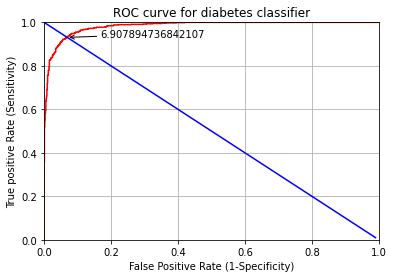

0.54445636

In [ ]:
print('********************Scores on devSet********************')
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/2_6/cnn_viT_8head_dropout0.3_relu1_144patches_128filter_blackman_frames400_sgd_epochs100_lr0.0001.h5')
#dev_yPred = model_cnn.predict_classes(x_dev)
dev_prediction = model.predict(x_dev)#prob of classes
dev_score = model.evaluate(x_dev, y_dev, verbose=1)

CalEER(devLabel,dev_prediction[:,1])
#analysisModel(devLabel,dev_yPred)

#print('dev loss:', dev_score[0])
#print('dev accuracy:', dev_score[1])

********************Scores on devSet********************
54/54 [==============================] - 2s 41ms/step - loss: 0.1762 - accuracy: 0.9316
eer_thresholds: 0.54445547
EER_fpr: 6.842105263157896
EER_fnr: 6.97368421052632
EER: 6.907894736842107


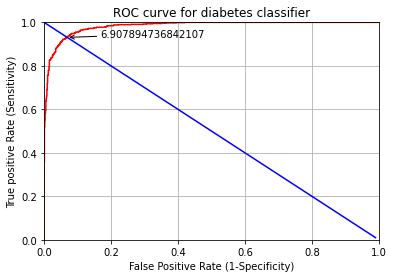

0.54445547

In [ ]:
print('********************Scores on devSet********************')
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/2_6/cnn_viT_8head_dropout0.3_relu1_144patches_128filter_blackman_frames400_sgd_epochs100_lr0.0001.h5')
#dev_yPred = model_cnn.predict_classes(x_dev)
dev_prediction = model.predict(x_dev)#prob of classes
dev_score = model.evaluate(x_dev, y_dev, verbose=1)

CalEER(devLabel,dev_prediction[:,1])
#analysisModel(devLabel,dev_yPred)

#print('dev loss:', dev_score[0])
#print('dev accuracy:', dev_score[1])

In [ ]:
print('dev loss:', dev_score[0])
print('dev accuracy:', dev_score[1])

dev loss: 0.21842949092388153
dev accuracy: 0.9333333373069763


In [ ]:
dev_yPred=np.where(dev_prediction[:,1] > 0.4344881, 1,0)
analysisModel(devLabel,dev_yPred)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       950
           1       0.92      0.94      0.93       760

    accuracy                           0.94      1710
   macro avg       0.93      0.94      0.94      1710
weighted avg       0.94      0.94      0.94      1710

TP: 711 FN: 49
FP: 60 TN: 890
Recall: 93.55263157894737
Specificity: 93.6842105263158
1-Specificity 6.315789473684211
Precision: 92.21789883268482


In [ ]:
del x_dev,y_dev,devLabel,devData,dev_prediction,dev_score,dev_yPred
import gc
gc.collect()

3060

#eval

In [ ]:
import pandas as pd

class StringConverter(dict):
    def __contains__(self, item):
        return True

    def __getitem__(self, item):
        return str

    def get(self, default=None):
        return str

df=pd.read_csv('/content/drive/MyDrive/protocol_V2/train_protocol.csv', converters=StringConverter())
test_df = pd.read_csv('/content/drive/MyDrive/protocol_V2/dev_protocol.csv', converters=StringConverter())
eval_df = pd.read_csv('/content/drive/MyDrive/protocol_V2/eval_protocol.csv', converters=StringConverter())

In [ ]:
classes=list(np.unique(eval_df.label))
classes[0], classes[1] = classes[1], classes[0]
classes

['spoof', 'genuine']

In [ ]:
fn2classes=dict(zip(eval_df.wav_id ,eval_df.label))

In [ ]:
def build_prediction(data_fram):
    y_true=[]
    y_pred=[]
    fn_prob={}
    #y_prob=[]

    print('prediction on eval dataset')
    for i, ID in enumerate(data_fram['wav_id']):
      feat= np.load(('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/feature_keras_generator/feature_keras_generator_400_400_100_800/' + ID.split(".")[0] + '.npy'))
      feat=feat.reshape(1, feat.shape[0], feat.shape[1], 1)
      label=fn2classes[ID]
      c=classes.index(label)
      y_hat=model.predict(feat)
      y_prob=[]
      y_prob.append(y_hat)
      y_pred.append(np.argmax(y_hat))
      y_true.append(c)
      fn_prob[ID]=np.mean(y_prob,axis=0).flatten()
    return y_true,y_pred,fn_prob

In [ ]:
path, dirs, files = next(os.walk("/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/feature_keras_generator/800_400"))
file_count = len(files)
print(file_count)

13306


In [ ]:
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/2_6/cnn_viT_8head_dropout0.3_relu1_144patches_128filter_blackman_frames400_sgd_epochs100_lr0.0001.h5')
y_true, y_pred, fn_prob=build_prediction(eval_df)

prediction on eval dataset


In [ ]:
print('********************Scores on EvalSet********************')
from sklearn.metrics import accuracy_score
Eval_acc=accuracy_score(y_true, y_pred)
print('Eval accuracy:', Eval_acc)

********************Scores on EvalSet********************
Eval accuracy: 0.8718623177513903


In [ ]:
print('********************Scores on EvalSet********************')
from sklearn.metrics import accuracy_score
Eval_acc=accuracy_score(y_true, y_pred)
print('Eval accuracy:', Eval_acc)

********************Scores on EvalSet********************
Eval accuracy: 0.8718623177513903


In [ ]:
y_probs=[]
for i , row in eval_df.iterrows():
  y_prob=fn_prob[row.wav_id]
  y_probs.append(y_prob)
  for c,p in zip(classes, y_prob):
    eval_df.at[i,c]=p

In [ ]:
y_pred=[classes[np.argmax(y)] for y in y_probs]
eval_df['y_pred']=y_pred
eval_df.to_csv('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/score_pred/prediction.csv', index=False)

In [ ]:
prediction=pd.read_csv('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/score_pred/prediction.csv')
prediction

,Unnamed: 0,wav_id,label,speaker_id,phrase_id,env_id,pb_device_id,rec_device_id,label_id,wav_path,transcript,duration,spoof,genuine,y_pred
0,0,E_1000001.wav,spoof,M0029,S03,E19,P22,R22,0,/content/drive/Shareddrives/Unlimited Drive | ...,Only lawyers love millionaires,4.1575,0.999342,0.000658,spoof
1,1,E_1000002.wav,spoof,M0027,S10,E19,P22,R22,0,/content/drive/Shareddrives/Unlimited Drive | ...,Necessity is the mother of invention,3.1745,0.996403,0.003597,spoof
2,2,E_1000003.wav,spoof,M0025,S01,E14,P03,R04,0,/content/drive/Shareddrives/Unlimited Drive | ...,My voice is my password,2.6215,0.132722,0.867278,genuine
3,3,E_1000004.wav,spoof,M0035,S10,E12,P16,R11,0,/content/drive/Shareddrives/Unlimited Drive | ...,Necessity is the mother of invention,2.3815,0.999761,0.000239,spoof
4,4,E_1000005.wav,spoof,M0025,S10,E18,P05,R03,0,/content/drive/Shareddrives/Unlimited Drive | ...,Necessity is the mother of invention,3.7725,0.767466,0.232534,spoof
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13301,13301,E_1014215.wav,spoof,M0023,S03,E24,P13,R08,0,/content/drive/Shareddrives/Unlimited Drive | ...,Only lawyers love millionaires,4.1255,0.010359,0.989641,genuine
13302,13302,E_1014216.wav,spoof,M0032,S01,E08,P20,R14,0,/content/drive/Shareddrives/Unlimited Drive | ...,My voice is my password,2.6265,0.997256,0.002744,spoof
13303,13303,E_1014217.wav,genuine,M0021,S04,-,-,-,1,/content/drive/Shareddrives/Unlimited Drive | ...,Artificial intelligence is for real,3.4535,0.467420,0.532580,genuine
13304,13304,E_1014218.wav,spoof,M0024,S06,E19,P22,R22,0,/content/drive/Shareddrives/Unlimited Drive | ...,Actions speak louder than words,4.1355,0.997074,0.002926,spoof


eer_thresholds: 0.77423257
EER_fpr: 9.618587608261159
EER_fnr: 9.553158705701081
EER: 9.58587315698112


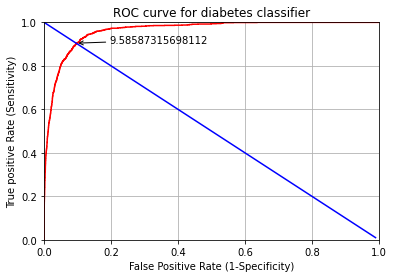

0.77423257

In [ ]:
CalEER(y_true,np.array(y_probs)[:,1])

eer_thresholds: 0.77423275
EER_fpr: 9.618587608261159
EER_fnr: 9.553158705701081
EER: 9.58587315698112


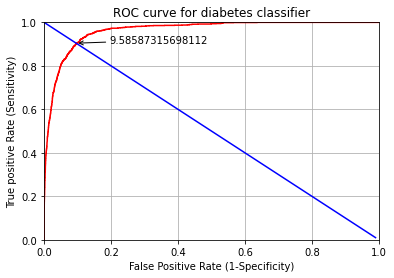

0.77423275

In [ ]:
CalEER(y_true,np.array(y_probs)[:,1])

EER: 9.58587315698112
EER: 6.907894736842107


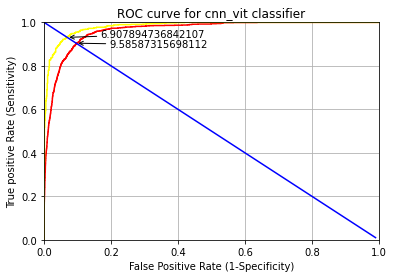

In [ ]:
fpr,tpr,thresholds = roc_curve(y_true,np.array(y_probs)[:,1])
fnr = 1 - tpr
fpr1,tpr1,thresholds1 = roc_curve(devLabel,dev_prediction[:,1])
fnr1 = 1 - tpr1
EER_fpr = fpr[np.nanargmin(np.absolute((fnr-fpr)))]
EER_fnr = fnr[np.nanargmin(np.absolute((fnr-fpr)))]
EER = (EER_fpr+EER_fnr)/2
EER_fpr1 = fpr1[np.nanargmin(np.absolute((fnr1-fpr1)))]
EER_fnr1 = fnr1[np.nanargmin(np.absolute((fnr1-fpr1)))]
EER1 = (EER_fpr1+EER_fnr1)/2
print ("EER:",EER*100)
print ("EER:",EER1*100)
plt.plot(fpr,tpr,color="red",label='Evaluation')
plt.plot(fpr1,tpr1,color="yellow",label='development')
plt.plot(np.arange(0.0,1.0,0.01),1.0-np.arange(0.0,1.0,0.01),color="blue")
plt.annotate(EER*100,xy=(EER,1-EER),xytext=(0.1+EER,1-EER-0.02),arrowprops=dict(arrowstyle='->',connectionstyle='arc3'))
plt.annotate(EER1*100,xy=(EER1,1-EER1),xytext=(0.1+EER1,1-EER1),arrowprops=dict(arrowstyle='->',connectionstyle='arc3'))
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title("ROC curve for cnn_vit classifier")
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True positive Rate (Sensitivity)")
plt.grid(True)
plt.show()

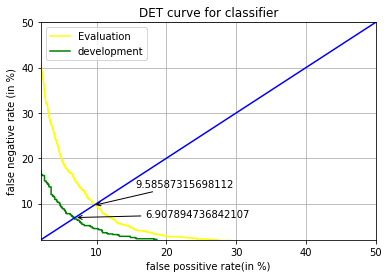

In [ ]:
fpr,tpr,thresholds = roc_curve(y_true,np.array(y_probs)[:,1])
fnr = 1 - tpr
EER_fpr = fpr[np.nanargmin(np.absolute((fnr-fpr)))]
EER_fnr = fnr[np.nanargmin(np.absolute((fnr-fpr)))]
EER = (EER_fpr+EER_fnr)/2
fpr1,tpr1,thresholds1 = roc_curve(devLabel,dev_prediction[:,1])
fnr1 = 1 - tpr1
EER_fpr1 = fpr1[np.nanargmin(np.absolute((fnr1-fpr1)))]
EER_fnr1 = fnr1[np.nanargmin(np.absolute((fnr1-fpr1)))]
EER1 = (EER_fpr1+EER_fnr1)/2
plt.plot(fpr*100,fnr*100,color="yellow",label='Evaluation')
plt.plot(fpr1*100,fnr1*100,color="green",label='development')
plt.plot(np.arange(0,100,1),np.arange(0,100,1),color="blue")
plt.annotate(EER*100,xy=(EER*100,EER*100),xytext=(EER*100+6,EER*100+4),
                 arrowprops=dict(arrowstyle='->',connectionstyle='arc3'))
plt.annotate(EER1*100,xy=(EER1*100,EER1*100),xytext=(EER1*100+10,EER1*100),arrowprops=dict(arrowstyle='->',connectionstyle='arc3'))
plt.xlim([2,50])
plt.ylim([2,50])
plt.title("DET curve for classifier")
plt.xlabel("false possitive rate(in %)")
plt.ylabel("false negative rate (in %)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
yPred=np.where(np.array(y_probs)[:,1] > 0.7396792, 1,0)
analysisModel(y_true,yPred)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     12008
           1       0.49      0.91      0.64      1298

    accuracy                           0.90     13306
   macro avg       0.74      0.90      0.79     13306
weighted avg       0.94      0.90      0.91     13306

TP: 1178 FN: 120
FP: 1225 TN: 10783
Recall: 90.75500770416025
Specificity: 89.79846768820786
1-Specificity 10.201532311792139
Precision: 49.0220557636288


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

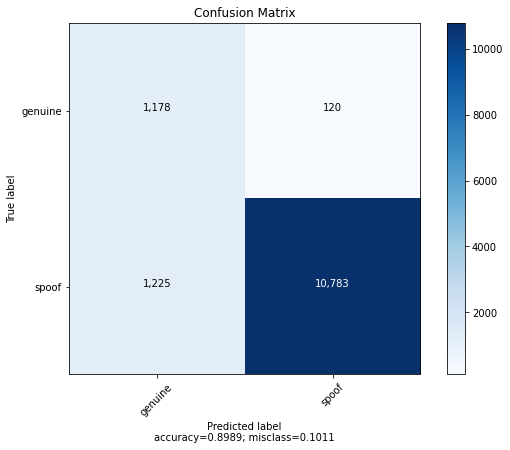

In [ ]:
plot_confusion_matrix(cm           = np.array([[ 1178 ,  120],
                                              [  1225 ,  10783]]), 
                      normalize    = False,
                      target_names = [ 'genuine','spoof' ],
                      title        = "Confusion Matrix")

#Eval1

In [ ]:
evalData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_864_400_100_800/eval/eval_1.npy')
evalLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_864_400_100_800/eval_lable/eval_1_label.npy')
img_rows, img_cols =evalData[0].shape
x_test = evalData.reshape(evalData.shape[0], img_rows, img_cols, 1)
y_test = keras.utils.np_utils.to_categorical(evalLabel,num_classes)
    

In [ ]:
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/lcnn_T_blackman_frames864_sgd_epochs25_lr0.001.h5')
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

120/120 [==============================] - 45s 234ms/step - loss: 0.5885 - accuracy: 0.7667
Test loss: 0.5884509086608887
Test accuracy: 0.7666579484939575


In [ ]:
del score
import gc
gc.collect()

875

********************Scores on testSet*********************
eer_thresholds: 0.65270096
EER_fpr: 16.61841343370006
EER_fnr: 16.621983914209114
EER: 16.620198673954587


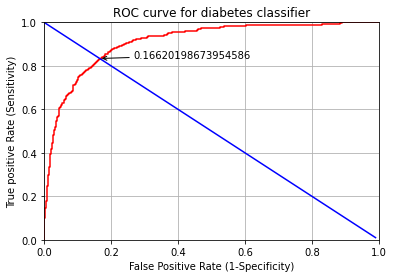

0.65270096

In [ ]:
print('********************Scores on testSet*********************')
#yPred = model.predict_classes(x_test)
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/lcnn_T_blackman_frames864_sgd_epochs25_lr0.001.h5')
prediction = model.predict(x_test)#prob of classes
#score = model.evaluate(x_test, y_test, verbose=1)

CalEER(evalLabel,prediction[:,1])
#analysisModel(evalLabel,yPred)

#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

In [ ]:
yPred=np.where(prediction[:,1] > 0.7396792, 1,0)
analysisModel(evalLabel,yPred)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3454
           1       0.51      0.90      0.65       373

    accuracy                           0.91      3827
   macro avg       0.75      0.90      0.80      3827
weighted avg       0.94      0.91      0.92      3827

TP: 337 FN: 36
FP: 325 TN: 3129
Recall: 90.3485254691689
Specificity: 90.59061957151128
1-Specificity 9.409380428488708
Precision: 50.90634441087614


#EVAL2

In [ ]:
evalData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_864_400_100_800/eval/eval_2.npy')
evalLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_864_400_100_800/eval_lable/eval_2_label.npy')
img_rows, img_cols =evalData[0].shape
x_test = evalData.reshape(evalData.shape[0], img_rows, img_cols, 1)
y_test = keras.utils.np_utils.to_categorical(evalLabel,num_classes)

In [ ]:
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/lcnn_T_blackman_frames864_sgd_epochs25_lr0.001.h5')
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

120/120 [==============================] - 47s 234ms/step - loss: 0.5995 - accuracy: 0.7618
Test loss: 0.5995193123817444
Test accuracy: 0.7617678046226501


In [ ]:
del score
import gc
gc.collect()

791

********************Scores on testSet*********************
eer_thresholds: 0.6327702
EER_fpr: 17.494226327944574
EER_fnr: 17.500000000000004
EER: 17.497113163972287


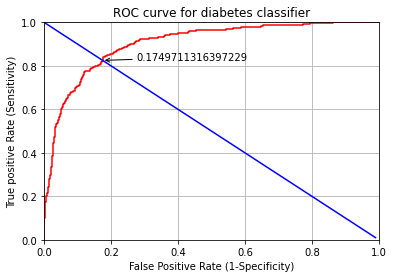

0.6327702

In [ ]:
print('********************Scores on testSet*********************')
#yPred = model.predict_classes(x_test)
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/lcnn_T_blackman_frames864_sgd_epochs25_lr0.001.h5')
prediction = model.predict(x_test)#prob of classes
#score = model.evaluate(x_test, y_test, verbose=1)

CalEER(evalLabel,prediction[:,1])
#analysisModel(evalLabel,yPred)

#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

In [ ]:
yPred=np.where(prediction[:,1] > 0.6327702, 1,0)
analysisModel(evalLabel,yPred)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      3464
           1       0.33      0.82      0.47       360

    accuracy                           0.83      3824
   macro avg       0.65      0.83      0.68      3824
weighted avg       0.92      0.83      0.86      3824

TP: 297 FN: 63
FP: 605 TN: 2859
Recall: 82.5
Specificity: 82.53464203233256
1-Specificity 17.465357967667437
Precision: 32.926829268292686


#EVAL3

In [ ]:
evalData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_864_400_100_800/eval/eval_3.npy')
evalLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_864_400_100_800/eval_lable/eval_3_label.npy')
img_rows, img_cols =evalData[0].shape
x_test = evalData.reshape(evalData.shape[0], img_rows, img_cols, 1)
y_test = keras.utils.np_utils.to_categorical(evalLabel,num_classes)

In [ ]:
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/lcnn_T_blackman_frames864_sgd_epochs25_lr0.001.h5')
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

80/80 [==============================] - 22s 134ms/step - loss: 0.3647 - accuracy: 0.8740
Test loss: 0.3647288680076599
Test accuracy: 0.8740188479423523


********************Scores on testSet*********************
eer_thresholds: 0.5703675
EER_fpr: 11.840354767184035
EER_fnr: 11.945392491467576
EER: 11.892873629325805


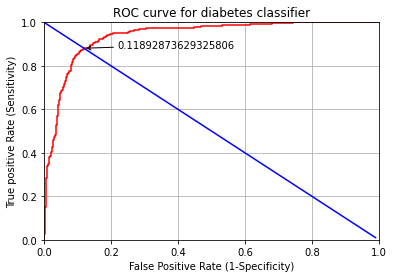

0.5703675

In [ ]:
print('********************Scores on testSet*********************')
#yPred = model.predict_classes(x_test)
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/lcnn_T_blackman_frames864_sgd_epochs25_lr0.001.h5')
prediction = model.predict(x_test)#prob of classes
#score = model.evaluate(x_test, y_test, verbose=1)

CalEER(evalLabel,prediction[:,1])
#analysisModel(evalLabel,yPred)

#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

In [ ]:
yPred=np.where(prediction[:,1] > 0.5703675, 1,0)
analysisModel(evalLabel,yPred)

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2255
           1       0.49      0.88      0.63       293

    accuracy                           0.88      2548
   macro avg       0.74      0.88      0.78      2548
weighted avg       0.93      0.88      0.89      2548

TP: 257 FN: 36
FP: 267 TN: 1988
Recall: 87.71331058020478
Specificity: 88.15964523281596
1-Specificity 11.840354767184035
Precision: 49.04580152671756


#EVAL4

In [ ]:
del score
import gc
gc.collect()

757

In [ ]:
evalData = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_864_400_100_800/eval/eval_4.npy')
evalLabel = np.load('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/log_power_spectrogram_864_400_100_800/eval_lable/eval_4_label.npy')
img_rows, img_cols =evalData[0].shape
x_test = evalData.reshape(evalData.shape[0], img_rows, img_cols, 1)
y_test = keras.utils.np_utils.to_categorical(evalLabel,num_classes)

In [ ]:
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/lcnn_T_blackman_frames864_sgd_epochs25_lr0.001.h5')
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

98/98 [==============================] - 15s 143ms/step - loss: 0.3700 - accuracy: 0.8693
Test loss: 0.3699861466884613
Test accuracy: 0.8693273067474365


********************Scores on testSet*********************
eer_thresholds: 0.6418277
EER_fpr: 11.146384479717813
EER_fnr: 11.397058823529417
EER: 11.271721651623615


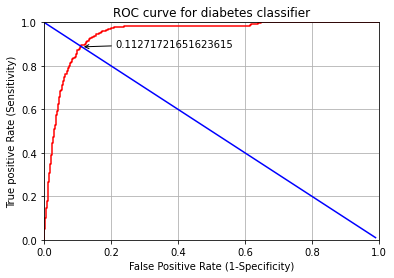

0.6418277

In [ ]:
print('********************Scores on testSet*********************')
#yPred = model.predict_classes(x_test)
model.load_weights('/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/models/lcnn_T_blackman_frames864_sgd_epochs25_lr0.001.h5')
prediction = model.predict(x_test)#prob of classes
#score = model.evaluate(x_test, y_test, verbose=1)

CalEER(evalLabel,prediction[:,1])
#analysisModel(evalLabel,yPred)

#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

In [ ]:
yPred=np.where(prediction[:,1] >0.6418277, 1,0)
analysisModel(evalLabel,yPred)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      2835
           1       0.43      0.89      0.58       272

    accuracy                           0.89      3107
   macro avg       0.71      0.89      0.76      3107
weighted avg       0.94      0.89      0.90      3107

TP: 241 FN: 31
FP: 315 TN: 2520
Recall: 88.60294117647058
Specificity: 88.88888888888889
1-Specificity 11.11111111111111
Precision: 43.3453237410072


In [ ]:
fpr,fnr,_=det_curve(devLabel,dev_prediction[:,1], pos_label=1)

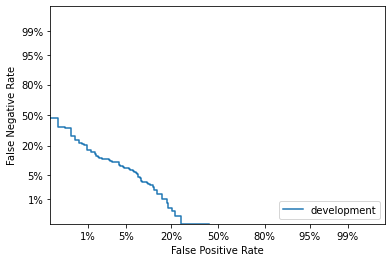

In [ ]:
display = DetCurveDisplay(fpr=fpr, fnr=fnr, estimator_name="development")
display.plot()
plt.show()

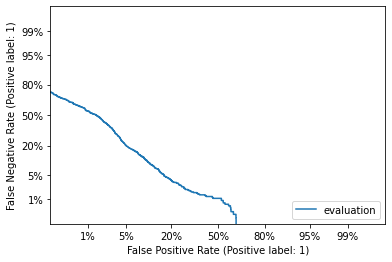

In [ ]:
DetCurveDisplay.from_predictions(y_true,np.array(y_probs)[:,1],name='evaluation')

In [ ]:
fpr1,fnr1,_=det_curve(y_true,np.array(y_probs)[:,1], pos_label=1)

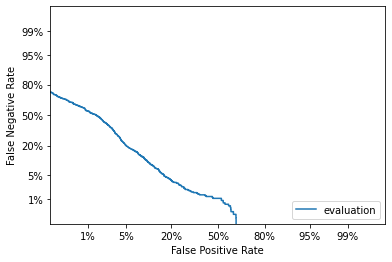

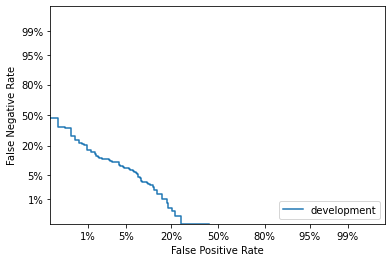

In [ ]:
display1 = DetCurveDisplay(fpr=fpr1, fnr=fnr1, estimator_name="evaluation")
display1.plot()
display.plot()
plt.show()